## Assessing model fit

In this chapter, you’ll learn how to ask questions of your model to assess fit. You’ll learn how to quantify how well a linear regression model fits, diagnose model problems using visualizations, and understand the leverage and influence of each observation used to create the model.

### Coefficient of determination
The coefficient of determination is a measure of how well the linear regression line fits the observed values. For simple linear regression, it is equal to the square of the correlation between the explanatory and response variables.

Here, you'll take another look at the second stage of the advertising pipeline: modeling the click response to impressions. Two models are available: mdl_click_vs_impression_orig models n_clicks versus n_impressions. mdl_click_vs_impression_trans is the transformed model you saw in Chapter 2. It models n_clicks ^ 0.25 versus n_impressions ^ 0.25.

In [3]:
# libraries
library(fst)
library(ggplot2)
library(dplyr)
library(broom)

# read and see data 
ad_conversion = read_fst("ad_conversion.fst")

# Run a linear regression of n_clicks to the power 0.25 vs.n_impressions to the power 0.25 using ad_conversion
mdl_click_vs_impression_trans <- lm(I(n_clicks^0.25) ~ I(n_impressions ^0.25), data = ad_conversion)

# Run a linear regression of n_clicks vs. n_impression
mdl_click_vs_impression_orig <- lm(n_clicks ~ n_impressions, data = ad_conversion)

# Print a summary of mdl_click_vs_impression_orig
summary(mdl_click_vs_impression_orig)

# Print a summary of mdl_click_vs_impression_trans
summary(mdl_click_vs_impression_trans)


Call:
lm(formula = n_clicks ~ n_impressions, data = ad_conversion)

Residuals:
     Min       1Q   Median       3Q      Max 
-186.099   -5.392   -1.422    2.070  119.876 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.683e+00  7.888e-01   2.133   0.0331 *  
n_impressions 1.718e-04  1.960e-06  87.654   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 19.91 on 934 degrees of freedom
Multiple R-squared:  0.8916,	Adjusted R-squared:  0.8915 
F-statistic:  7683 on 1 and 934 DF,  p-value: < 2.2e-16



Call:
lm(formula = I(n_clicks^0.25) ~ I(n_impressions^0.25), data = ad_conversion)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57061 -0.13229  0.00582  0.14494  0.46888 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.0717479  0.0172019   4.171 3.32e-05 ***
I(n_impressions^0.25) 0.1115330  0.0008844 126.108  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1969 on 934 degrees of freedom
Multiple R-squared:  0.9445,	Adjusted R-squared:  0.9445 
F-statistic: 1.59e+04 on 1 and 934 DF,  p-value: < 2.2e-16


In [4]:
# Get coeff of determination for mdl_click_vs_impression_orig
mdl_click_vs_impression_orig %>% 
  # Get the model-level details
  glance() %>%
  # pull r.squared
  pull(r.squared)


# Do the same for the transformed model
mdl_click_vs_impression_trans %>% 
  # Get the model-level details
  glance() %>%
  # pull r.squared
  pull(r.squared)


[1] 0.8916135

[1] 0.9445273

### Residual standard error
Residual standard error (RSE) is a measure of the typical size of the residuals. Equivalently, it's a measure of how badly wrong you can expect predictions to be. Smaller numbers are better, with zero being a perfect fit to the data.

In [6]:
# Get RSE for mdl_click_vs_impression_orig
mdl_click_vs_impression_orig %>% 
  # Get the model-level details
   glance()%>% 
  # Pull out sigma
  pull(sigma)

# Do the same for the transformed model
mdl_click_vs_impression_trans %>% 
  # Get the model-level details
   glance()%>% 
  # Pull out sigma
  pull(sigma)


[1] 19.90584

[1] 0.1969064

###  Drawing diagnostic plots
It's time for you to draw these diagnostic plots yourself. Let's go back to the Taiwan real estate dataset and the model of house prices versus number of convenience stores.

autoplot() lets you specify which diagnostic plots you are interested in.

1. residuals vs. fitted values
2. Q-Q plot
3. scale-location

Warning message:
"`arrange_()` is deprecated as of dplyr 0.7.0.
Please use `arrange()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

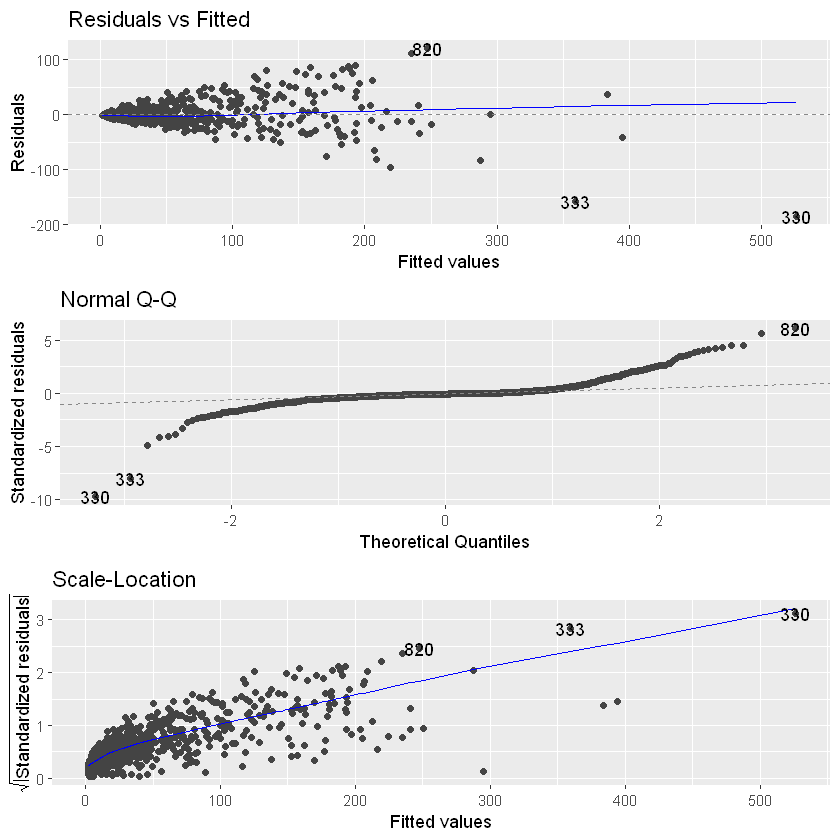

In [10]:
# install and libraries
# install.packages("ggfortify")
library(ggfortify)
library(ggplot2)
# autoplot give us a plot to check model fit 
autoplot(mdl_click_vs_impression_orig, which = 1:3, nrow = 3, ncol = 1)

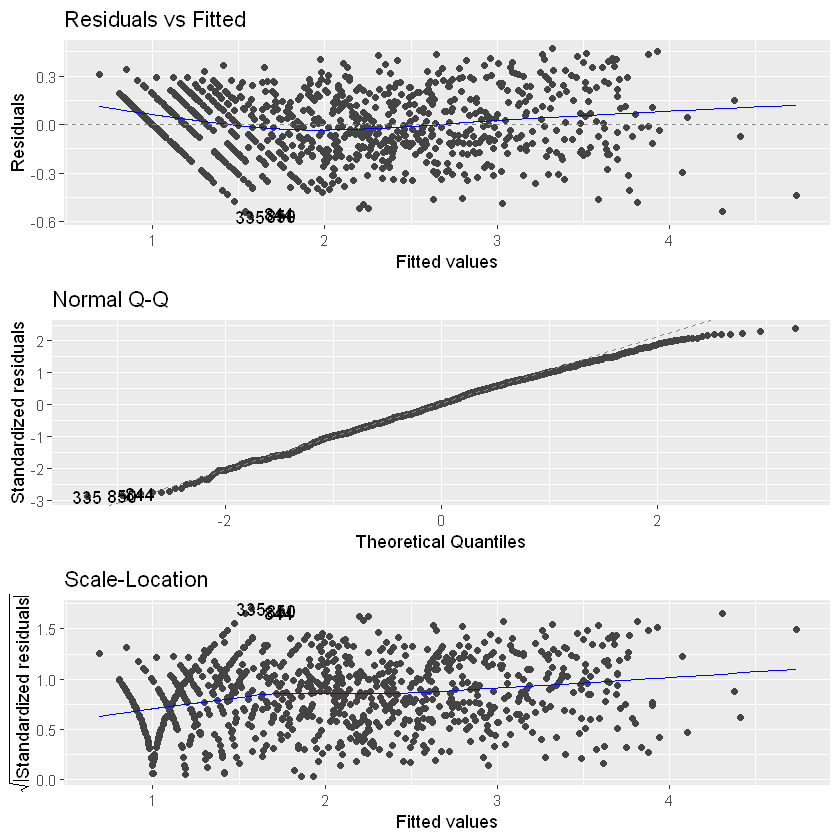

In [11]:
# Now with transformed model
autoplot(mdl_click_vs_impression_trans, which = 1:3, nrow = 3, ncol = 1)

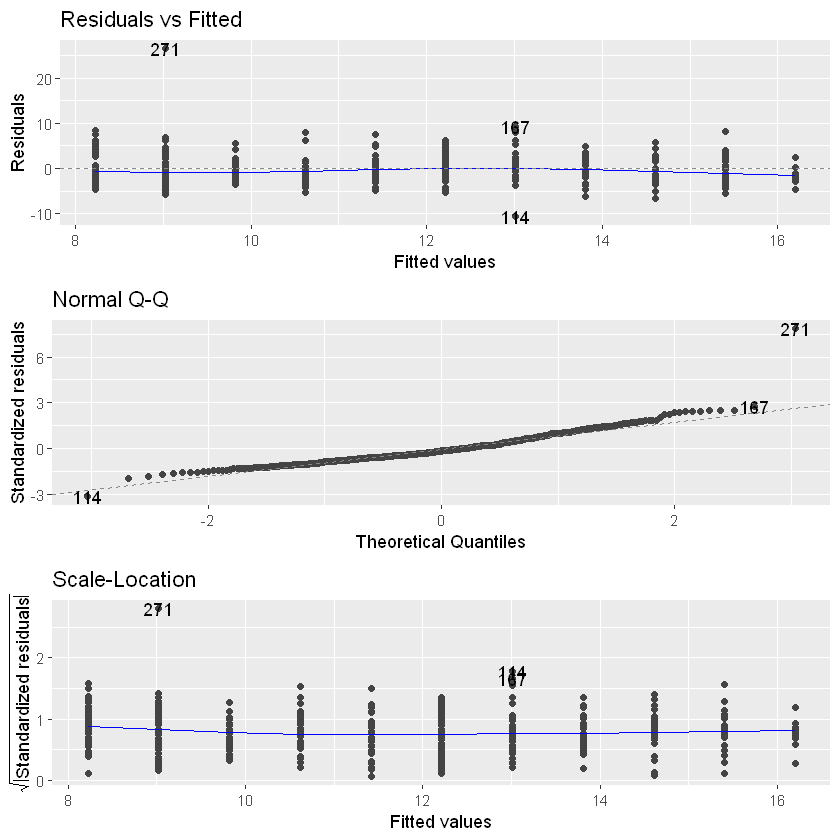

In [15]:
# other model, remember taiwan real state...
# read and see data 
taiwan_real_estate = read_fst("taiwan_real_estate.fst")
# linear regression model of house price versus number of convenience 
mdl_price_vs_conv = lm(price_twd_msq ~ n_convenience, data = taiwan_real_estate)
# Plot the three diagnostics for mdl_price_vs_conv
autoplot(mdl_price_vs_conv, which = 1:3, nrow = 3, ncol = 1)



### Outliers, leverage, and influence

1. Leverage measures how unusual or extreme the explanatory variables are for each observation. Very roughly, a high leverage means that the explanatory variable has values that are different to other points in the dataset. In the case of simple linear regression, where there is only one explanatory value, this typically means values with a very high or very low explanatory value.

So, observations with a large distance to the nearest MRT station have the highest leverage, because most of the observations have a short distance, so long distances are more extreme.

2. Influence measures how much a model would change if each observation was left out of the model calculations, one at a time. That is, it measures how different the prediction line would look if you ran a linear regression on all data points except that point, compared to running a linear regression on the whole dataset.

The standard metric for influence is Cook's distance, which calculates influence based on the size of the residual and the leverage of the point.

So, observations with predictions far away from the trend line have high influence, because they have large residuals and are far away from other observations.

### Extracting leverage and influence
In the last few exercises you explored which observations had the highest leverage and influence. Now you'll extract those values from an augmented version of the model, and visualize them.

In [16]:
# linear regression model of house price versus number of convenience 
mdl_price_vs_dist = lm(price_twd_msq ~ sqrt(dist_to_mrt_m), data = taiwan_real_estate)

mdl_price_vs_dist %>% 
  # Augment the model
  augment() %>% 
  # Arrange rows by descending leverage
  arrange(desc(.hat)) %>%  # for historical reasons, .hat design influence
  # Get the head of the dataset
  head()

price_twd_msq,sqrt(dist_to_mrt_m),.fitted,.hat,.sigma,.cooksd,.std.resid
3.388805,80.54825,1.982126,0.02666524,2.820143,0.0035077120,0.50604061
3.691377,79.97677,2.086619,0.02613525,2.819879,0.0044695281,0.57714091
4.538578,79.41129,2.190012,0.02561660,2.818577,0.0093730405,0.84442186
5.688351,74.24310,3.134978,0.02114202,2.818146,0.0090604283,0.91595888
5.264750,74.24310,3.134978,0.02114202,2.819021,0.0063035699,0.76400271
4.054463,67.86567,4.301046,0.01628058,2.820993,0.0000644269,-0.08823672


In [17]:
mdl_price_vs_dist %>% 
  # Augment the model
  augment() %>% 
  # Arrange rows by descending Cook's distance
  arrange(desc(.cooksd)) %>% 
  # Get the head of the dataset
  head()

price_twd_msq,sqrt(dist_to_mrt_m),.fitted,.hat,.sigma,.cooksd,.std.resid
35.552194,15.89283,13.803908,0.003849038,2.608234,0.11554872,7.733642
13.645991,61.48650,5.467431,0.012147330,2.791667,0.05244008,2.920467
14.099849,56.31455,6.413085,0.009331845,2.795181,0.03538436,2.740949
23.691377,13.65687,14.212738,0.004400819,2.781831,0.02512289,3.371517
2.299546,19.83080,13.083879,0.003095203,2.770253,0.02281295,-3.833434
23.600605,17.84739,13.446532,0.003440129,2.776044,0.02249375,3.610025


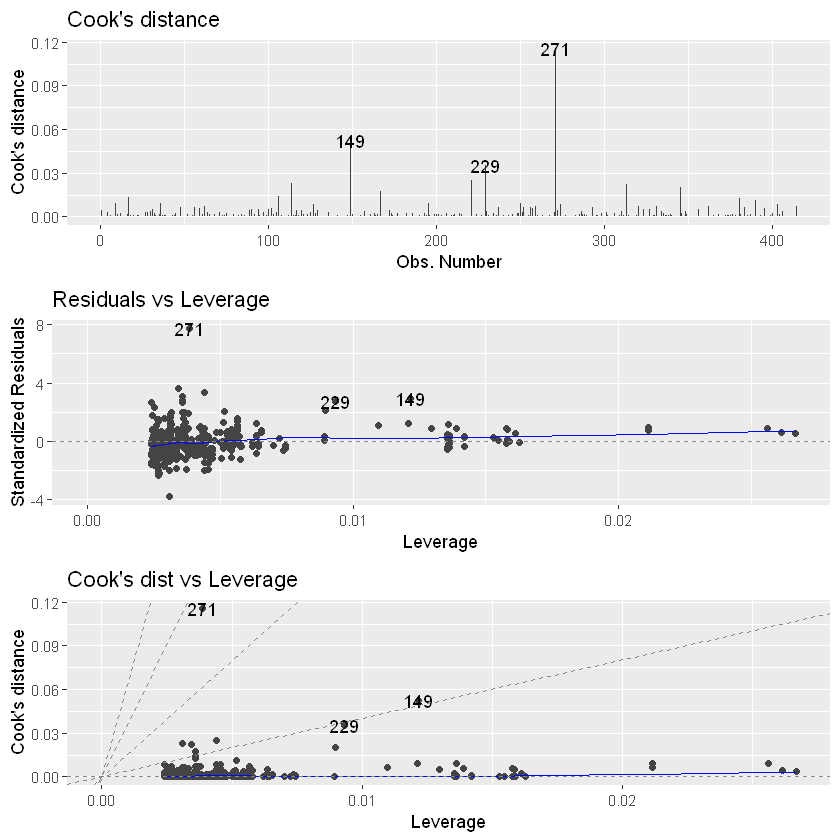

In [18]:
# Plot the three outlier diagnostic plots (numbered 4 to 6) for mdl_price_vs_dist. Use a layout of three rows and one column.

# Plot the three outlier diagnostics for mdl_price_vs_dist
autoplot(mdl_price_vs_dist, which = 4:6, nrow = 3, ncol = 1)